# Recommending products with RetailRocket event logs

This IPython notebook illustrates the usage of the [ctpfrec](https://github.com/david-cortes/ctpfrec/) Python package for _Collaborative Topic Poisson Factorization_ in recommender systems based on sparse count data using the [RetailRocket](https://www.kaggle.com/retailrocket/ecommerce-dataset) dataset, consisting of event logs (view, add to cart, purchase) from an online catalog of products plus anonymized text descriptions of items.

Collaborative Topic Poisson Factorization is a probabilistic model that tries to jointly factorize the user-item interaction matrix along with item-word text descriptions (as bag-of-words) of the items by the product of lower dimensional matrices. The package can also extend this model to add user attributes in the same format as the items’.

Compared to competing methods such as BPR (Bayesian Personalized Ranking) or weighted-implicit NMF (non-negative matrix factorization of the non-probabilistic type that uses squared loss), it only requires iterating over the data for which an interaction was observed and not over data for which no interaction was observed (i.e. it doesn’t iterate over items not clicked by a user), thus being more scalable, and at the same time producing better results when fit to sparse count data (in general). Same for the word counts of items.

The implementation here is based on the paper _Content-based recommendations with poisson factorization (Gopalan, P.K., Charlin, L. and Blei, D., 2014)_.

For a similar package for explicit feedback data see also [cmfrec](https://github.com/david-cortes/cmfrec/). For Poisson factorization without side information see [hpfrec](https://github.com/david-cortes/hpfrec/)

**Small note: if the TOC here is not clickable or the math symbols don't show properly, try visualizing this same notebook from nbviewer following [this link](http://nbviewer.jupyter.org/github/david-cortes/ctpfrec/blob/master/example/ctpfrec_retailrocket.ipynb).**

** *
## Sections
* [1. Model description](#p1)
* [2. Loading and processing the dataset](#p2)
* [3. Fitting the model](#p3)
* [4. Common sense checks](#p4)
* [5. Comparison to model without item information](#p5)
* [6. Making recommendations](#p6)
* [7. References](#p7)
** *
<a id="p1"></a>
## 1. Model description

The model consists in producing a low-rank non-negative matrix factorization of the item-word matrix (a.k.a. bag-of-words, a matrix where each row represents an item and each column a word, with entries containing the number of times each word appeared in an item’s text, ideally with some pre-processing on the words such as stemming or lemmatization) by the product of two lower-rank matrices

$$ W_{iw} \approx \Theta_{ik} \beta_{wk}^T $$

along with another low-rank matrix factorization of the user-item activity matrix (a matrix where each entry corresponds to how many times each user interacted with each item) that shares the same item-factor matrix above plus an offset based on user activity and not based on items’ words

$$ Y_{ui} \approx \eta_{uk} (\Theta_{ik} + \epsilon_{ik})^T $$

These matrices are assumed to come from a generative process as follows:

* Items:

$$ \beta_{wk} \sim Gamma(a,b) $$
$$ \Theta_{ik} \sim Gamma(c,d)$$
$$ W_{iw} \sim Poisson(\Theta_{ik} \beta_{wk}^T) $$
_(Where $W$ is the item-word count matrix, $k$ is the number of latent factors, $i$ is the number of items, $w$ is the number of words)_

* User-Item interactions
$$ \eta_{uk} \sim Gamma(e,f) $$
$$ \epsilon_{ik} \sim Gamma(g,h) $$
$$ Y_{ui} \sim Poisson(\eta_{uk} (\Theta_{ik} + \epsilon_{ik})^T) $$
_(Where $u$ is the number of users, $Y$ is the user-item interaction matrix)_

The model is fit using mean-field variational inference with coordinate ascent. For more details see the paper in the references.
** *
<a id="p2"></a>
## 2. Loading and processing the data

Reading and concatenating the data. First the event logs:

In [1]:
import numpy as np, pandas as pd

events = pd.read_csv("events.csv")
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [2]:
events.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In order to put all user-item interactions in one scale, I will arbitrarily assign values as follows:
* View: +1
* Add to basket: +3
* Purchase: +3

Thus, if a user clicks an item, that `(user, item)` pair will have `value=1`, if she later adds it to cart and purchases it, will have `value=7` (plus any other views of the same item), and so on.

The reasoning behind this scale is because the distributions of counts and sums of counts seem to still follow a nice exponential distribution with these values, but different values might give better results in terms of models fit to them.

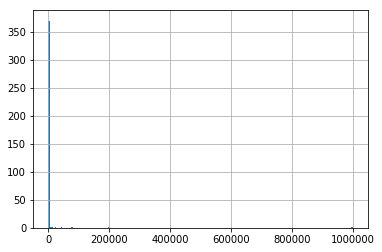

In [3]:
%matplotlib inline

equiv = {
    'view':1,
    'addtocart':3,
    'transaction':3
}
events['count']=events.event.map(equiv)
events.groupby('visitorid')['count'].sum().value_counts().hist(bins=200)

In [4]:
events = events.groupby(['visitorid','itemid'])['count'].sum().to_frame().reset_index()
events.rename(columns={'visitorid':'UserId', 'itemid':'ItemId', 'count':'Count'}, inplace=True)
events.head()

,UserId,ItemId,Count
0,0,67045,1
1,0,285930,1
2,0,357564,1
3,1,72028,1
4,2,216305,2


Now creating a train and test split. For simplicity purposes and in order to be able to make a fair comparison with a model that doesn't use item descriptions, I will try to only take users that had >= 3 items in the training data, and items that had >= 3 users. Given the lack of user attributes, the test set will only have users from the training data, but it's also possible to use user attributes if they follow the same format as the items'.

In order to compare it later to a model without items' text, I will also filter out the test set to have only items that were in the training set. **This is however not a model limitation, as it can also recommend items that have descriptions but no user interactions**.

In [5]:
from sklearn.model_selection import train_test_split

events_train, events_test = train_test_split(events, test_size=.2, random_state=1)
del events

## In order to find users and items with at least 3 interactions each,
## it's easier and faster to use a simple heuristic that first filters according to one criteria,
## then, according to the other, and repeats.
## Finding a real subset of the data in which each item has strictly >= 3 users,
## and each user has strictly >= 3 items, is a harder graph partitioning or optimization
## problem. For a similar example of finding such subsets see also:
## http://nbviewer.ipython.org/github/david-cortes/datascienceprojects/blob/master/optimization/dataset_splitting.ipynb
users_filter_out = events_train.groupby('UserId')['ItemId'].agg(lambda x: len(tuple(x)))
users_filter_out = np.array(users_filter_out.index[users_filter_out < 3])

items_filter_out = events_train.loc[~np.in1d(events_train.UserId, users_filter_out)].groupby('ItemId')['UserId'].agg(lambda x: len(tuple(x)))
items_filter_out = np.array(items_filter_out.index[items_filter_out < 3])

users_filter_out = events_train.loc[~np.in1d(events_train.ItemId, items_filter_out)].groupby('UserId')['ItemId'].agg(lambda x: len(tuple(x)))
users_filter_out = np.array(users_filter_out.index[users_filter_out < 3])

events_train = events_train.loc[~np.in1d(events_train.UserId.values, users_filter_out)]
events_train = events_train.loc[~np.in1d(events_train.ItemId.values, items_filter_out)]
events_test = events_test.loc[np.in1d(events_test.UserId.values, events_train.UserId.values)]
events_test = events_test.loc[np.in1d(events_test.ItemId.values, events_train.ItemId.values)]

print(events_train.shape)
print(events_test.shape)

(381963, 3)
(68490, 3)


Now processing the text descriptions of the items:

In [6]:
iteminfo = pd.read_csv("item_properties_part1.csv")
iteminfo2 = pd.read_csv("item_properties_part2.csv")
iteminfo = iteminfo.append(iteminfo2, ignore_index=True)
iteminfo.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


The item's description contain many fields and have a mixture of words and numbers. The numeric variables, as per the documentation, are prefixed with an "n" and have three digits decimal precision - I will exclude them here since this model is insensitive to numeric attributes such as price. The words are already lemmazed, and since we only have their IDs, it's not possible to do any other pre-processing on them.

Although the descriptions don't say anything about it, looking at the contents and the lengths of the different fields, here I will assume that the field $283$ is the product title and the field $888$ is the product description. I will just concatenate them to obtain an overall item text, but there might be better ways of doing this (such as having different IDs for the same word when it appears in the title or the body, or multiplying those in the title by some number, etc.)

As the descriptions vary over time, I will only take the most recent version for each item:

In [7]:
iteminfo = iteminfo.loc[iteminfo.property.isin(('888','283'))]
iteminfo = iteminfo.loc[iteminfo.groupby(['itemid','property'])['timestamp'].idxmax()]
iteminfo.reset_index(drop=True, inplace=True)
iteminfo.head()

,timestamp,itemid,property,value
0,1431226800000,0,283,66094 372274 478989
1,1433041200000,0,888,478989
2,1435460400000,1,283,513325 1020281 1204938 172646 72261 30603 8980...
3,1442113200000,1,888,172646 1154859
4,1431226800000,2,283,822092 325894 504272 147366 343631 648485 n600...


**Note that for simplicity I am completely ignoring the categories (these are easily incorporated e.g. by adding a count of +1 for each category to which an item belongs) and important factors such as the price. I am also completely ignoring all the other fields.**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix
import re

def concat_fields(x):
    x = list(x)
    out = x[0]
    for i in x[1:]:
        out += " " + i
    return out

class NonNumberTokenizer(object):
    def __init__(self):
        pass
    def __call__(self, txt):
        return [i for i in txt.split(" ") if bool(re.search("^\d", i))]

iteminfo = iteminfo.groupby('itemid')['value'].agg(lambda x: concat_fields(x))

t = CountVectorizer(tokenizer=NonNumberTokenizer(), stop_words=None,
                    dtype=np.int32, strip_accents=None, lowercase=False)
bag_of_words = t.fit_transform(iteminfo)

bag_of_words = coo_matrix(bag_of_words)
bag_of_words = pd.DataFrame({
    'ItemId' : iteminfo.index[bag_of_words.row],
    'WordId' : bag_of_words.col,
    'Count' : bag_of_words.data
})
del iteminfo
bag_of_words.head()

,ItemId,WordId,Count
0,0,194496,2
1,0,164052,1
2,0,245598,1
3,1,44188,1
4,1,286671,1


In this case, I will not filter it out by only items that were in the training set, as other items can still be used to get better latent factors.

** *
<a id="p3"></a>
## 3. Fitting the model

Fitting the model - note that I'm using some enhancements (passed as arguments to the class constructor) over the original version in the paper:
* Standardizing item counts so as not to favor items with longer descriptions.
* Initializing $\Theta$ and $\beta$ through hierarchical Poisson factorization instead of latent Dirichlet allocation.
* Using a small step size for the updates for the parameters obtained from hierarchical Poisson factorization at the beginning, which then grows to one with increasing iteration numbers (informally, this achieves to somehwat "preserve" these fits while the user parameters are adjusted to these already-fit item parameters - then as the user parameters are already defined towards them, the user parameters start chaning too).

I'll be also fitting two slightly different models: one that takes (and can make recommendations for) all the items for which there are either descriptions or user clicks, and another that uses all the items for which there are descriptions to initialize the item-related parameters but discards them afterwards (can only make recommendations for items that users have clicked).

For more information about the parameters and what they do, see the online documentation:

[http://ctpfrec.readthedocs.io](http://ctpfrec.readthedocs.io)

In [9]:
print(events_train.shape)
print(events_test.shape)
print(bag_of_words.shape)

(381963, 3)
(68490, 3)
(7676561, 3)


In [10]:
%%time
from ctpfrec import CTPF

recommender_all_items = CTPF(k=70, step_size=lambda x: 1-1/np.sqrt(x+1),
                   standardize_items=True, initialize_hpf=True, reindex=True,
                   missing_items='include', allow_inconsistent_math=True, random_seed=1)
recommender_all_items.fit(counts_df=events_train.copy(), words_df=bag_of_words.copy())

*****************************************
Collaborative Topic Poisson Factorization
*****************************************

Number of users: 65913
Number of items: 418301
Number of words: 342260
Latent factors to use: 70

Initializing parameters...
Initializing Theta and Beta through HPF...

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 417053
Number of items: 342260
Latent factors to use: 70

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | Norm(Theta_{10} - Theta_{0}): 3373.40234
Iteration 20 | Norm(Theta_{20} - Theta_{10}): 13.27828
Iteration 30 | Norm(Theta_{30} - Theta_{20}): 11.13377
Iteration 40 | Norm(Theta_{40} - Theta_{30}): 5.31448
Iteration 50 | Norm(Theta_{50} - Theta_{40}): 3.22818
Iteration 60 | Norm(Theta_{60} - Theta_{50}): 2.55681
Iteration 70 | Norm(Theta_{70} - Theta_{60}): 1.98294
Iteration 80 | Norm(Theta_{80} - Theta_{70}): 1.90

In [11]:
%%time
recommender_clicked_items_only = CTPF(k=70, step_size=lambda x: 1-1/np.sqrt(x+1),
                   standardize_items=True, initialize_hpf=True, reindex=True,
                   missing_items='exclude', allow_inconsistent_math=True, random_seed=1)
recommender_clicked_items_only.fit(counts_df=events_train.copy(), words_df=bag_of_words.copy())

*****************************************
Collaborative Topic Poisson Factorization
*****************************************



/home/david_cortes_rivera/ctpfrec/ctpfrec.py:463: UserWarning: Some words are associated only with items that are in 'words_df' but not in 'counts_df'. These will be used to initialize Beta but will be excluded from the final model. If you still wish to include them in the model, use 'missing_items='include''. For information about which words are used by the model, see the attribute 'word_mapping_'.
  warnings.warn(msg)


Number of users: 65913
Number of items: 39578
Number of words: 67980
Latent factors to use: 70

Initializing parameters...
Initializing Theta and Beta through HPF...

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 417053
Number of items: 342260
Latent factors to use: 70

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | Norm(Theta_{10} - Theta_{0}): 3373.40234
Iteration 20 | Norm(Theta_{20} - Theta_{10}): 13.27671
Iteration 30 | Norm(Theta_{30} - Theta_{20}): 11.13745
Iteration 40 | Norm(Theta_{40} - Theta_{30}): 5.31671
Iteration 50 | Norm(Theta_{50} - Theta_{40}): 3.23314
Iteration 60 | Norm(Theta_{60} - Theta_{50}): 2.55311
Iteration 70 | Norm(Theta_{70} - Theta_{60}): 1.98616
Iteration 80 | Norm(Theta_{80} - Theta_{70}): 1.89440
Iteration 90 | Norm(Theta_{90} - Theta_{80}): 1.50197
Iteration 100 | Norm(Theta_{100} - Theta_{90}): 1.18714


Optimization 

Most of the time here was spent in fitting the model to items that no user in the training set had clicked. If using instead a random initialization, it would have taken a lot less time to fit this model (there would be only a fraction of the items - see above time spent in each procedure), but the results are slightly worse.

_Disclaimer: this notebook was run on a Google cloud server with Skylake CPU using 8 cores, and memory usage tops at around 6GB of RAM for the first model (including all the objects loaded before). In a desktop computer, it would take a bit longer to fit._
** *
<a id="p4"></a>
## 4. Common sense checks

There are many different metrics to evaluate recommendation quality in implicit datasets, but all of them have their drawbacks. The idea of this notebook is to illustrate the package usage and not to introduce and compare evaluation metrics, so I will only perform some common sense checks on the test data.

For implementations of evaluation metrics for implicit recommendations see other packages such as [lightFM](https://github.com/lyst/lightfm).

As some common sense checks, the predictions should:
* Be higher for this non-zero hold-out sample than for random items.
* Produce a good discrimination between random items and those in the hold-out sample (very related to the first point).
* Be correlated with the playcounts in the hold-out sample.
* Follow an exponential distribution rather than a normal or some other symmetric distribution.

Here I'll check these four conditions:

#### Model with all items

In [12]:
events_test['Predicted'] = recommender_all_items.predict(user=events_test.UserId, item=events_test.ItemId)
events_test['RandomItem'] = np.random.choice(events_train.ItemId, size=events_test.shape[0])
events_test['PredictedRandom'] = recommender_all_items.predict(user=events_test.UserId, item=events_test.RandomItem)
print("Average prediction for combinations in test set: ", events_test.Predicted.mean())
print("Average prediction for random combinations: ", events_test.PredictedRandom.mean())

Average prediction for combinations in test set:  0.017797707
Average prediction for random combinations:  0.017258095


In [13]:
from sklearn.metrics import roc_auc_score

was_clicked = np.r_[np.ones(events_test.shape[0]), np.zeros(events_test.shape[0])]
score_model = np.r_[events_test.Predicted.values, events_test.PredictedRandom.values]
roc_auc_score(was_clicked[~np.isnan(score_model)], score_model[~np.isnan(score_model)])

0.5993077019811273

In [14]:
np.corrcoef(events_test.Count[~events_test.Predicted.isnull()], events_test.Predicted[~events_test.Predicted.isnull()])[0,1]

0.12013594880233261

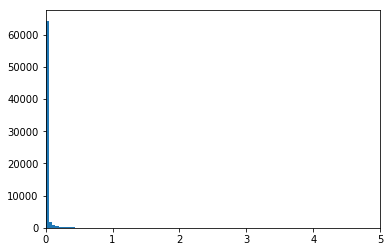

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.hist(events_test.Predicted, bins=200)
plt.xlim(0,5)
plt.show()

#### Model with clicked items only

In [16]:
events_test['Predicted'] = recommender_clicked_items_only.predict(user=events_test.UserId, item=events_test.ItemId)
events_test['RandomItem'] = np.random.choice(events_train.ItemId, size=events_test.shape[0])
events_test['PredictedRandom'] = recommender_clicked_items_only.predict(user=events_test.UserId, item=events_test.RandomItem)
print("Average prediction for combinations in test set: ", events_test.Predicted.mean())
print("Average prediction for random combinations: ", events_test.PredictedRandom.mean())

Average prediction for combinations in test set:  0.025655648
Average prediction for random combinations:  0.02036544


In [17]:
was_clicked = np.r_[np.ones(events_test.shape[0]), np.zeros(events_test.shape[0])]
score_model = np.r_[events_test.Predicted.values, events_test.PredictedRandom.values]
roc_auc_score(was_clicked, score_model)

0.5944568975446632

In [18]:
np.corrcoef(events_test.Count, events_test.Predicted)[0,1]

0.06981233580659989

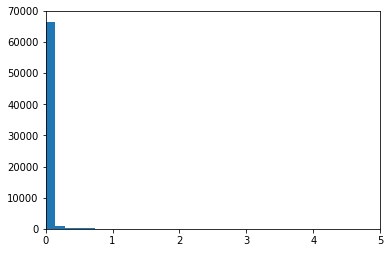

In [19]:
_ = plt.hist(events_test.Predicted, bins=200)
plt.xlim(0,5)
plt.show()

** *
<a id="p5"></a>
## 5. Comparison to model without item information

A natural benchmark to compare this model is to is a Poisson factorization model without any item side information - here I'll do the comparison with a _Hierarchical Poisson factorization_ model with the same metrics as above:

In [20]:
%%time
from hpfrec import HPF

recommender_no_sideinfo = HPF(k=70)
recommender_no_sideinfo.fit(events_train.copy())

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 65913
Number of items: 39578
Latent factors to use: 70

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -4634419 | train rmse: 2.8515
Iteration 20 | train llk: -4548152 | train rmse: 2.8444
Iteration 30 | train llk: -4514595 | train rmse: 2.8405
Iteration 40 | train llk: -4498025 | train rmse: 2.8395
Iteration 50 | train llk: -4486481 | train rmse: 2.8393
Iteration 60 | train llk: -4477149 | train rmse: 2.8392
Iteration 70 | train llk: -4468932 | train rmse: 2.8392
Iteration 80 | train llk: -4459521 | train rmse: 2.8390
Iteration 90 | train llk: -4450894 | train rmse: 2.8390
Iteration 100 | train llk: -4442274 | train rmse: 2.8392


Optimization finished
Final log-likelihood: -4442274
Final RMSE: 2.8392
Minutes taken (optimization part): 1.6

CPU times: user 12min 43s, sys: 2.31 s, total: 12min 45

In [21]:
events_test_comp = events_test.copy()
events_test_comp['Predicted'] = recommender_no_sideinfo.predict(user=events_test_comp.UserId, item=events_test_comp.ItemId)
events_test_comp['RandomItem'] = np.random.choice(events_test_comp.ItemId, size=events_test_comp.shape[0])
events_test_comp['PredictedRandom'] = recommender_no_sideinfo.predict(user=events_test_comp.UserId, item=events_test_comp.RandomItem)
print("Average prediction for combinations in test set: ", events_test_comp.Predicted.mean())
print("Average prediction for random combinations: ", events_test_comp.PredictedRandom.mean())

Average prediction for combinations in test set:  0.017622134
Average prediction for random combinations:  0.020480338


In [22]:
was_clicked = np.r_[np.ones(events_test_comp.shape[0]), np.zeros(events_test_comp.shape[0])]
score_model = np.r_[events_test_comp.Predicted.values, events_test_comp.PredictedRandom.values]
roc_auc_score(was_clicked, score_model)

0.5871667314626097

In [23]:
np.corrcoef(events_test_comp.Count, events_test_comp.Predicted)[0,1]

0.04429450093952786

As can be seen, adding the side information results in an over all 3 metrics, especially correlation with number of clicks.

More important than that however, is its ability to make recommendations from a far wider catalog of items, which in practice can make a much larger difference in recommendation quality than improvement in typicall offline metrics.
** *
<a id="p6"></a>
## 6. Making recommendations

The package provides a simple API for making predictions and Top-N recommended lists. These Top-N lists can be made among all items, or across some user-provided subset only, and you can choose to discard items with which the user had already interacted in the training set.

Here I will:
* Pick a random user with a reasonably long event history.
* See which items would the model recommend to them among those which he has not yet clicked.
* Compare it with the recommended list from the model without item side information.

Unfortunately, since all the data is anonymized, it's not possible to make a qualitative evaluation of the results by looking at the recommended lists as it is in other datasets.

In [24]:
users_many_events = events_train.groupby('UserId')['ItemId'].agg(lambda x: len(tuple(x)))
users_many_events = np.array(users_many_events.index[users_many_events > 20])

np.random.seed(1)
chosen_user = np.random.choice(users_many_events)
chosen_user

1362222

In [25]:
%%time
recommender_all_items.topN(chosen_user, n=20)

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 25.7 ms


array([  9877, 119736, 312728, 241555, 257040, 325310, 320130, 445351,
       409804, 384302, 219512,  38965, 234255, 303828,  37029, 248455,
       309778, 190000, 290999, 213834])

*(These numbers represent the IDs of the items being recommended as they appeared in the `events_train` data frame)*

In [26]:
%%time
recommender_clicked_items_only.topN(chosen_user, n=20)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 1.98 ms


array([119736, 441852, 372188, 344723, 116624, 439963, 345279, 183511,
         4001,  33912, 354585, 456056,  29940, 272324,  89323, 186702,
       190000, 227790,  92361,  78729])

In [27]:
%%time
recommender_no_sideinfo.topN(chosen_user, n=20)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 1.91 ms


array([339703,  65273, 186256,  17478, 198784, 354881, 449489,  73602,
       120098, 383717, 395435,  78163, 285055, 402455, 319723,  33907,
       257070, 157705, 350689, 460553])

** *
<a id="p7"></a>
## 7. References
* Gopalan, Prem K., Laurent Charlin, and David Blei. "Content-based recommendations with poisson factorization." Advances in Neural Information Processing Systems. 2014.